In [1]:
import time
import random
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score


seed = 13
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
gpu = torch.device("cuda" if torch.cuda.is_available() else "cpu") 
print(gpu)  


cuda


In [2]:
# Set the dimensions of the input data
m = 1000
d = 1000

# Set the number of labels
k = 50

In [3]:
class SyntheticDataset:
    def __init__(self, n_samples=1000, n_features=1000, n_classes=50, seed=13):
        """
        Initialize synthetic dataset generator
        
        Args:
            n_samples:  number of samples
            n_features: number of features
            n_classes:  number of classes
            device:     computation device
            seed:       random seed
        """
        self.m = n_samples
        self.d = n_features
        self.k = n_classes
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.seed = seed
        
        # Set seed
        random.seed(self.seed)
        np.random.seed(self.seed)
        torch.manual_seed(seed)
        torch.cuda.manual_seed(seed)
        
        # Generate dataset
        self._generate_data()
        
    def _generate_data(self):
        """Generate synthetic data"""
        
        # Generate random input A
        self.A = np.random.randn(self.m, self.d)
        #print(f"A: {self.A}")
        
        # Generate random matrix X
        self.X = np.random.randn(self.d, self.k)    
        #print(f"X: {self.X}")
        
        # Generate random error matrix E
        self.E = np.random.randn(self.m, self.k)
        #print(f"E: {self.E}")
                
        # Generate class labels
        Y = self.A @ self.X + self.E
        self.B = np.argmax(Y, axis=1) + 1
        #print(f"B: {self.B}")
        
        # Create one-hot encoding matrix H
        self.H = pd.get_dummies(self.B).astype(float).values
        #print(f"H: {self.H}")
        
        # Create ones vector M
        self.M = np.ones((1, self.m))

        
        # Create ones vector K
        self.K = np.ones((self.k, 1))
        
        # Normalize weights with Xavier initialization
        self.X_train = np.random.randn(self.d, self.k) * np.sqrt(1 / self.d)
        #print(f"X_train: {self.X_train}")
        
        
        
    def get_data(self):
        """Return all dataset components"""
        if self.device != "cpu":
            self.X_train = torch.tensor(self.X_train, device=self.device)
            self.A = torch.tensor(self.A, device=self.device)
            self.H = torch.tensor(self.H, device=self.device)
            self.M = torch.tensor(self.M, device=self.device)
            self.K = torch.tensor(self.K, device=self.device)
            self.B = torch.tensor(self.B, device=self.device)
        
        return self.X_train, self.A, self.H, self.M, self.K, self.B
    

dataset = SyntheticDataset(n_samples=1000, n_features=1000, n_classes=50, seed=13)

In [4]:
X_gpu, A_gpu, H_gpu, M_gpu, K_gpu, B_gpu = dataset.get_data()
X_cpu, A_cpu, H_cpu, M_cpu, K_cpu, B_cpu = X_gpu.cpu().numpy(), A_gpu.cpu().numpy(), H_gpu.cpu().numpy(), M_gpu.cpu().numpy(), K_gpu.cpu().numpy(), B_gpu.cpu().numpy()

In [5]:
assert np.allclose(X_cpu, X_gpu.cpu().numpy())
assert np.allclose(A_cpu, A_gpu.cpu().numpy())
assert np.allclose(H_cpu, H_gpu.cpu().numpy())
assert np.allclose(M_cpu, M_gpu.cpu().numpy())
assert np.allclose(K_cpu, K_gpu.cpu().numpy())
assert np.allclose(B_cpu, B_gpu.cpu().numpy())


# Cost function

In [6]:
def compute_cost_cpu(X, A, H, M, K):

    # Compute the exponential of AX
    exp_AX = np.exp(A @ X)

    # Compute the log of the exponential of AX
    log = np.log(exp_AX @ K)

    # Compute the diagonal of the matrix product
    diag = np.diag((A @ X) @ H.T)[:, np.newaxis]

    # Compute the cost
 
    cost = M @ ( - diag + log )

    return cost.item()

# Compute the gradient of the cost function
cost = compute_cost_cpu(X_cpu, A_cpu, H_cpu, M_cpu, K_cpu)

# Print the cost

print('Cost:', cost)

Cost: 4365.026231881989


In [7]:
def compute_cost_gpu(X, A, H, M, K):
    """
    Compute the vectorized cost function using PyTorch operations.
    
    Args:
        X: Input tensor
        A: Matrix A
        H: Matrix H 
        M: Matrix M
        K: Ones tensor
        
    Returns:
        Cost value as a scalar
    """
    
    # Compute the exponential of AX
    exp_AX = torch.exp(A @ X)

    # Compute the log of the exponential of AX
    log = torch.log(exp_AX @ K)

    # Compute the diagonal of the matrix product
    diag = torch.diag((A @ X) @ H.T)[:, None]

    # Compute the cost
    cost = M @ (- diag + log)

    return cost.item()

# Compute the gradient of the cost function
cost = compute_cost_gpu(X_gpu, A_gpu, H_gpu, M_gpu, K_gpu)

# Print the cost
print('Cost:', cost)

Cost: 4365.02623188199


In [8]:
assert np.isclose(compute_cost_cpu(X_cpu, A_cpu, H_cpu, M_cpu, K_cpu), compute_cost_gpu(X_gpu, A_gpu, H_gpu, M_gpu, K_gpu))

# Accuracy

In [9]:
# Compute the softmax function using NumPy
def softmax(matrix):
    # Exponentiate the shift matrix
    exps = np.exp(matrix)

    # Compute the softmax matrix
    softmax_matrix = exps / np.sum(exps, axis=0, keepdims=True)

    return softmax_matrix

In [10]:
# CPU implementation
def compute_accuracy_cpu(X, A, B, index_0=True):

    # Compute the softmax of the matrix product
    Y_pred = softmax(A @ X)

    if index_0 == True:
        # Get the index of the maximum value in each row
        B_pred = np.argmax(Y_pred, axis=1)

    else:
        # Get the index of the maximum value in each row
        B_pred = np.argmax(Y_pred, axis=1) + 1

    # Compute the accuracy of the model
    accuracy = accuracy_score(B, B_pred)

    return accuracy

accuracy_cpu = compute_accuracy_cpu(X_cpu, A_cpu, B_cpu)

print('Accuracy:', accuracy_cpu)

Accuracy: 0.019


In [11]:
# GPU version

def accuracy_score_gpu(y_true, y_pred):
    
    # Compute the accuracy of the model
    accuracy = torch.sum(y_true == y_pred).float() / y_true.shape[0]

    return accuracy.item()




def compute_accuracy_gpu(X, A, B, index_0=True):

    # Compute the softmax of the matrix product
    Y_pred = torch.nn.functional.softmax(A @ X, dim=0)


    if index_0 == True:
        # Get the index of the maximum value in each row
        B_pred = torch.argmax(Y_pred, dim=1)

    else:
        # Get the index of the maximum value in each row
        B_pred = torch.argmax(Y_pred, dim=1) + 1

    # Compute the accuracy of the model
    
    accuracy = accuracy_score_gpu(B, B_pred)

    return accuracy


accuracy_gpu = compute_accuracy_gpu(X_gpu, A_gpu, B_gpu)

print('Accuracy:', accuracy_gpu)

Accuracy: 0.01900000125169754


In [12]:
Y_pred_cpu = softmax(A_cpu @ X_cpu) 
Y_pred_gpu = torch.nn.functional.softmax(A_gpu @ X_gpu, dim=0)

print('Y_pred_cpu:', Y_pred_cpu)
print('Y_pred_gpu:', Y_pred_gpu)

Y_pred_cpu: [[3.84566082e-04 7.94674381e-04 8.33944364e-04 ... 8.98158523e-04
  1.13071307e-03 1.21832336e-03]
 [4.53652067e-03 1.13443448e-04 5.67530872e-04 ... 7.01270522e-04
  1.55643244e-04 9.88229179e-04]
 [8.32167947e-04 7.06369024e-04 1.07814387e-03 ... 1.33396681e-03
  4.61266396e-04 5.69727853e-04]
 ...
 [1.40366164e-03 1.09551287e-03 1.13839201e-04 ... 1.11284975e-03
  4.34246758e-04 1.27991847e-03]
 [8.80852486e-04 4.90402919e-04 5.90929050e-04 ... 1.93253824e-04
  4.19979584e-04 2.42557697e-05]
 [2.49510331e-04 5.66630254e-04 1.41446040e-03 ... 1.20491752e-03
  6.87934806e-04 8.77860674e-03]]
Y_pred_gpu: tensor([[3.8457e-04, 7.9467e-04, 8.3394e-04,  ..., 8.9816e-04, 1.1307e-03,
         1.2183e-03],
        [4.5365e-03, 1.1344e-04, 5.6753e-04,  ..., 7.0127e-04, 1.5564e-04,
         9.8823e-04],
        [8.3217e-04, 7.0637e-04, 1.0781e-03,  ..., 1.3340e-03, 4.6127e-04,
         5.6973e-04],
        ...,
        [1.4037e-03, 1.0955e-03, 1.1384e-04,  ..., 1.1128e-03, 4.3425e-0

In [13]:
assert np.isclose(compute_accuracy_cpu(X_cpu, A_cpu, B_cpu), compute_accuracy_gpu(X_gpu, A_gpu, B_gpu))

# Gradient

In [14]:
# CPU implementation
def gradient_cpu(X, A, H, K):

    # Compute the exponential of A @ X
    exp_AX = np.exp(A @ X)

    # Compute the derivative of the loss function with respect to X
    df_dX = - A.T @ (H - (exp_AX * (1 / (exp_AX @ K))))  # Perform broadcasting between exp_AX and (1 / (exp_AX @ I)) instead of compting the C matrix

    return df_dX

print('Gradient CPU:', gradient_cpu(X_cpu, A_cpu, H_cpu, K_cpu))

Gradient CPU: [[-4.2416887  -1.63765546  4.64962977 ... -3.49680882 -2.98012839
   8.27944512]
 [ 6.89796423 -0.8737726   7.68001854 ... -1.93752301 -3.57376666
   5.4840611 ]
 [ 4.54852217  4.81075999 -5.58602402 ... -9.12775714 -0.47941134
  -7.08780965]
 ...
 [ 1.54767785 -3.07158962 -0.17057505 ...  2.57090769 -1.78023225
  -3.42591692]
 [-0.5860776  10.4326188  -5.87404158 ... -3.03621608  1.58723474
  -1.99958676]
 [ 3.11195133  3.10083908  6.17721249 ... -0.46954968 -0.92179899
   2.17967824]]


In [15]:
# GPU implementation
def gradient_gpu(X, A, H, K):

    # Compute the exponential of A @ X
    exp_AX = torch.exp(A @ X)

    # Compute the derivative of the loss function with respect to X
    df_dX = - A.T @ (H - (exp_AX * (1 / (exp_AX @ K))) )

    return df_dX

print('Gradient GPU:', gradient_gpu(X_gpu, A_gpu, H_gpu, K_gpu))

Gradient GPU: tensor([[-4.2417, -1.6377,  4.6496,  ..., -3.4968, -2.9801,  8.2794],
        [ 6.8980, -0.8738,  7.6800,  ..., -1.9375, -3.5738,  5.4841],
        [ 4.5485,  4.8108, -5.5860,  ..., -9.1278, -0.4794, -7.0878],
        ...,
        [ 1.5477, -3.0716, -0.1706,  ...,  2.5709, -1.7802, -3.4259],
        [-0.5861, 10.4326, -5.8740,  ..., -3.0362,  1.5872, -1.9996],
        [ 3.1120,  3.1008,  6.1772,  ..., -0.4695, -0.9218,  2.1797]],
       device='cuda:0', dtype=torch.float64)


In [16]:
assert np.allclose(gradient_cpu(X_cpu, A_cpu, H_cpu, K_cpu), gradient_gpu(X_gpu, A_gpu, H_gpu, K_gpu).cpu().numpy())

# Gradient block

In [17]:
# CPU implementation
def gradient_block_cpu(X, A, H, K, index):

        # Select the index-th column of X
        X_c = X[:, index:index+1]

        # Compute the exponential of A @ X
        exp_AX = np.exp(A @ X)

        # Compute the exponential of A @ X for the index-th column
        exp_AX_c = np.exp(A @ X_c)

        # Select the index-th column of the one-hot matrix
        H_c = H[:, index:index+1]

        # Compute the derivative of the loss function with respect to X
        df_dX_c = - A.T @ (H_c - (exp_AX_c * (1 / (exp_AX @ K))))  # Perform broadcasting between exp_AX and (1 / (exp_AX @ I))

        return df_dX_c

print('Gradient block CPU:', gradient_block_cpu(X_cpu, A_cpu, H_cpu, K_cpu, 0))

Gradient block CPU: [[-4.24168870e+00]
 [ 6.89796423e+00]
 [ 4.54852217e+00]
 [-4.72179827e+00]
 [ 5.74557533e+00]
 [-6.37645183e-01]
 [-1.51719552e+00]
 [-1.68197467e+00]
 [ 3.07561104e+00]
 [-5.89641317e+00]
 [-4.90992688e+00]
 [-6.97861331e+00]
 [-4.15606610e+00]
 [-1.14157227e+00]
 [ 5.80265290e+00]
 [-1.71761143e+00]
 [-9.76405732e+00]
 [-3.40760927e+00]
 [ 3.84798813e+00]
 [-5.55835233e+00]
 [-7.71740571e-01]
 [ 3.95604572e+00]
 [-7.13053592e+00]
 [ 2.46635708e+00]
 [-7.29412220e+00]
 [ 4.81021528e-01]
 [ 9.59652677e+00]
 [-1.76135463e+00]
 [-9.46779544e+00]
 [-1.16278880e+00]
 [-4.37376767e+00]
 [ 6.64681129e+00]
 [ 2.03661627e+00]
 [ 3.19644528e+00]
 [-2.10171218e+00]
 [ 5.85570650e+00]
 [ 6.49177912e+00]
 [-3.01719554e+00]
 [-5.99118032e+00]
 [-2.56822693e+00]
 [ 1.24302551e+00]
 [ 1.23277359e+00]
 [ 2.12392719e+00]
 [-2.62376958e+00]
 [-1.63582712e+00]
 [ 2.32658849e+00]
 [ 8.99859287e-01]
 [-5.84539987e+00]
 [ 7.66656935e+00]
 [-1.65423586e+00]
 [-1.07885926e+01]
 [ 1.571112

In [18]:
# GPU implementation
def gradient_block_gpu(X, A, H, K, index):

        # Select the index-th column of X
        X_c = X[:, index:index+1]

        # Compute the exponential of A @ X
        exp_AX = torch.exp(A @ X)

        # Compute the exponential of A @ X for the index-th column
        exp_AX_c = torch.exp(A @ X_c)

        # Select the index-th column of the one-hot matrix
        H_c = H[:, index:index+1]

        # Compute the derivative of the loss function with respect to X
        df_dX_c = - A.T @ (H_c - (exp_AX_c * (1 / (exp_AX @ K))) )

        return df_dX_c
    
print('Gradient block GPU:', gradient_block_gpu(X_gpu, A_gpu, H_gpu, K_gpu, 0))

Gradient block GPU: tensor([[-4.2417e+00],
        [ 6.8980e+00],
        [ 4.5485e+00],
        [-4.7218e+00],
        [ 5.7456e+00],
        [-6.3765e-01],
        [-1.5172e+00],
        [-1.6820e+00],
        [ 3.0756e+00],
        [-5.8964e+00],
        [-4.9099e+00],
        [-6.9786e+00],
        [-4.1561e+00],
        [-1.1416e+00],
        [ 5.8027e+00],
        [-1.7176e+00],
        [-9.7641e+00],
        [-3.4076e+00],
        [ 3.8480e+00],
        [-5.5584e+00],
        [-7.7174e-01],
        [ 3.9560e+00],
        [-7.1305e+00],
        [ 2.4664e+00],
        [-7.2941e+00],
        [ 4.8102e-01],
        [ 9.5965e+00],
        [-1.7614e+00],
        [-9.4678e+00],
        [-1.1628e+00],
        [-4.3738e+00],
        [ 6.6468e+00],
        [ 2.0366e+00],
        [ 3.1964e+00],
        [-2.1017e+00],
        [ 5.8557e+00],
        [ 6.4918e+00],
        [-3.0172e+00],
        [-5.9912e+00],
        [-2.5682e+00],
        [ 1.2430e+00],
        [ 1.2328e+00],
        [ 2.12

In [19]:
assert np.allclose(gradient_block_cpu(X_cpu, A_cpu, H_cpu, K_cpu, 0), gradient_block_gpu(X_gpu, A_gpu, H_gpu, K_gpu, 0).cpu().numpy())

# Lipschitz function

In [20]:
# CPU implementation
def Lipschitz_constant_cpu(A):
    L = np.linalg.norm(A, 2) * np.linalg.norm(A, 'fro')
    return L

L_cpu = Lipschitz_constant_cpu(A_cpu)

print('Lipschitz constant:', L_cpu)

Lipschitz constant: 62332.083415006935


In [21]:
# GPU implementation
def Lipschitz_constant_gpu(A):
    L = torch.linalg.norm(A, 2) * torch.linalg.norm(A, 'fro')
    return L

L_gpu = Lipschitz_constant_gpu(A_gpu)

print('Lipschitz constant:', L_gpu)

Lipschitz constant: tensor(62332.0834, device='cuda:0', dtype=torch.float64)


In [22]:
norm2_cpu = np.linalg.norm(A_cpu, 2)
norm_fro_cpu = np.linalg.norm(A_cpu, 'fro')
norm2_gpu = torch.linalg.norm(A_gpu, 2)
norm_fro_gpu = torch.linalg.norm(A_gpu, 'fro')
print(f'CPU norm2: {norm2_cpu}, CPU norm_fro: {norm_fro_cpu}')
print(f'GPU norm2: {norm2_gpu}, GPU norm_fro: {norm_fro_gpu}')


CPU norm2: 62.361347433264555, CPU norm_fro: 999.5307346703992
GPU norm2: 62.36134743327395, GPU norm_fro: 999.5307346703992


In [23]:
assert np.isclose(Lipschitz_constant_cpu(A_cpu), Lipschitz_constant_gpu(A_gpu).cpu().numpy())

# Gradient Descent

In [24]:
n_iter = 1000
learning_rate = 1 / L_cpu
tolerance = 1e-6

In [25]:
def gradient_descent_cpu(X, A, H, K, alpha, num_iterations, epsilon):

    # Store the history of the norm, time and update to visualize the convergence
    norm_history = []
    time_history = []
    update_history = []

    # Compute the gradient of the loss function with respect to X
    grad = gradient_cpu(X, A, H, K)

    # Initialize the iteration
    i = 0

    # Loop for a number of iterations
    while i < num_iterations and np.linalg.norm(grad) > epsilon:


        ## Step 1: start the timer
        start = time.time()

        ## Step 2: update the parameters
        X = X - alpha * grad

        ## Step 3: update the gradient of the loss function with respect to the new X
        grad = gradient_cpu(X, A, H, K)

        ## Step 4: end the timer
        end = time.time()

        ## Step 5: save the time to the history
        time_history.append(end - start)

        ## Step 6: save the norm to the history
        norm_history.append(np.linalg.norm(grad))

        ## Step 7: store the current X
        update_history.append(X)

        ## Step 8: update the iteration
        i += 1

    return X, norm_history, time_history, update_history


# Run the gradient descent algorithm
X_GD_CPU, norm_history_GD_CPU, time_history_GD_CPU, update_history_GD_CPU = gradient_descent_cpu(X_cpu, A_cpu, H_cpu, K_cpu, learning_rate, n_iter, tolerance)

print('Gradient descent CPU:', X_GD_CPU)

Gradient descent CPU: [[-0.02805076 -0.02414506 -0.05137511 ...  0.03154081  0.02219599
  -0.04019471]
 [-0.03984501 -0.01307903 -0.05815383 ...  0.02744134  0.01625796
  -0.02601091]
 [-0.04312911  0.04546166  0.00638661 ...  0.06493866  0.02316599
   0.0348591 ]
 ...
 [-0.03119636  0.01781614 -0.01128832 ... -0.00794128 -0.00343814
   0.01383049]
 [-0.04081123 -0.08230708  0.04398007 ...  0.04145922 -0.06460764
   0.01864041]
 [ 0.00360285 -0.00109459 -0.09453132 ...  0.03095003  0.01533804
   0.01482712]]


In [26]:
def gradient_descent_gpu(X, A, H, K, alpha, num_iterations, epsilon):

    # Store the history of the norm, time and update to visualize the convergence
    norm_history = []
    time_history = []
    update_history = []


    # Compute the gradient of the loss function with respect to X
    grad = gradient_gpu(X, A, H, K)

    # Initialize the iteration
    i = 0

    # Loop for a number of iterations
    while i < num_iterations and torch.linalg.norm(grad) > epsilon:


        ## Step 1: start the timer
        start = time.time()

        ## Step 2: update the parameters
        X = X - alpha * grad

        ## Step 3: update the gradient of the loss function with respect to the new X
        grad = gradient_gpu(X, A, H, K)

        ## Step 4: end the timer
        end = time.time()

        ## Step 5: save the time to the history
        time_history.append(end - start)

        ## Step 6: save the norm to the history
        norm_history.append(torch.linalg.norm(grad))

        ## Step 7: store the current X
        update_history.append(X)

        ## Step 8: update the iteration
        i += 1

    return X, norm_history, time_history, update_history


# Run the gradient descent algorithm
X_GD_GPU, norm_history_GD_GPU, time_history_GD_GPU, update_history_GD_GPU = gradient_descent_gpu(X_gpu, A_gpu, H_gpu, K_gpu, learning_rate, n_iter, tolerance)

print('Gradient descent GPU:', X_GD_GPU)

Gradient descent GPU: tensor([[-0.0281, -0.0241, -0.0514,  ...,  0.0315,  0.0222, -0.0402],
        [-0.0398, -0.0131, -0.0582,  ...,  0.0274,  0.0163, -0.0260],
        [-0.0431,  0.0455,  0.0064,  ...,  0.0649,  0.0232,  0.0349],
        ...,
        [-0.0312,  0.0178, -0.0113,  ..., -0.0079, -0.0034,  0.0138],
        [-0.0408, -0.0823,  0.0440,  ...,  0.0415, -0.0646,  0.0186],
        [ 0.0036, -0.0011, -0.0945,  ...,  0.0310,  0.0153,  0.0148]],
       device='cuda:0', dtype=torch.float64)


In [27]:
assert np.allclose(X_GD_CPU, X_GD_GPU.cpu().numpy())

# BCGD Randomized

In [28]:
def BCDG_randomized_cpu(X, A, H, K, alpha, num_iterations, epsilon, j):

    # Store the history of the norm, time and cost to visualize the convergence
    norm_history = []
    time_history = []
    update_history = []

    # Compute the gradient of the loss function with respect to X
    grad = gradient_cpu(X, A, H, K)

    # Initialize the iteration
    i = 0

    # Loop for a number of iterations
    while i < num_iterations and np.linalg.norm(grad) > epsilon:

        ## Step 1: start the timer
        start = time.time()

        ## Step 2: randomly select a block
        rand_index = np.random.randint(0, j)          # randomly select a block


        ## Step 4: compute the gradient of the block
        random_gradient_block_new = gradient_block_cpu(X, A, H, K, rand_index)

        ## Step 5: update the block
        grad[:, rand_index:rand_index+1] = random_gradient_block_new

        ## Step 6: update the parameters
        X = X - alpha * grad

        ## Step 7: end the timer
        end = time.time()

        ## Step 8: save the time to the history
        time_history.append(end - start)

        ## Step 9: save the norm to the history
        norm_history.append(np.linalg.norm(grad))

        ## Step 10: store the current X
        update_history.append(X)

        ## Step 11: update the iteration
        i += 1

    return X, norm_history, time_history, update_history

# Run the BCDG algorithm
X_BCGD_R_CPU, norm_history_BCGD_R_CPU, time_history_BCGD_R_CPU, update_history_BCGD_R_CPU = BCDG_randomized_cpu(X_cpu, A_cpu, H_cpu, K_cpu, learning_rate, n_iter, tolerance, 10)

print('BCGD Randomized CPU:', X_BCGD_R_CPU)

BCGD Randomized CPU: [[-0.02553535 -0.03083707 -0.05568235 ...  0.06746253  0.05859978
  -0.12933307]
 [-0.04483715 -0.01185581 -0.06155059 ...  0.0518696   0.05102139
  -0.08883798]
 [-0.04838638  0.04496182  0.00650927 ...  0.14872118  0.02534631
   0.11107551]
 ...
 [-0.03582165  0.01934532 -0.0091251  ... -0.035255    0.02030053
   0.04875944]
 [-0.04314158 -0.09215194  0.04314617 ...  0.07066738 -0.07572039
   0.04346636]
 [ 0.00319407  0.0021725  -0.10499875 ...  0.03610681  0.01665754
  -0.01314275]]


In [29]:
def BCDG_randomized_gpu(X, A, H, K, alpha, num_iterations, epsilon, j):
    # Store histories
    norm_history = []
    time_history = []
    update_history = []
    
    # Compute initial gradient
    grad = gradient_gpu(X, A, H, K)
    
    i = 0
    while i < num_iterations and torch.norm(grad) > epsilon:
        start = time.time()
        
        # Random block selection
        rand_index = torch.randint(0, j, (1,)).item()
        
        # Update gradient block
        random_gradient_block = gradient_block_gpu(X, A, H, K, rand_index)
        grad[:, rand_index:rand_index+1] = random_gradient_block
        
        # Update parameters
        X = X - alpha * grad
        
        end = time.time()
        
        # Store history
        time_history.append(end - start)
        norm_history.append(torch.norm(grad).item())
        update_history.append(X.clone())
        
        i += 1
        
    return X, norm_history, time_history, update_history

# Run algorithm
X_BCGD_R_GPU, norm_history_BCGD_R_GPU, time_history_BCGD_R_GPU, update_history_BCGD_R_GPU = BCDG_randomized_gpu(X_gpu, A_gpu, H_gpu, K_gpu, learning_rate, n_iter, tolerance, 10)

print('BCGD Randomized GPU:', X_BCGD_R_GPU)

BCGD Randomized GPU: tensor([[-0.0255, -0.0307, -0.0557,  ...,  0.0675,  0.0586, -0.1293],
        [-0.0448, -0.0118, -0.0616,  ...,  0.0519,  0.0510, -0.0888],
        [-0.0484,  0.0448,  0.0065,  ...,  0.1487,  0.0253,  0.1111],
        ...,
        [-0.0358,  0.0194, -0.0091,  ..., -0.0353,  0.0203,  0.0488],
        [-0.0432, -0.0921,  0.0431,  ...,  0.0707, -0.0757,  0.0435],
        [ 0.0032,  0.0021, -0.1050,  ...,  0.0361,  0.0167, -0.0131]],
       device='cuda:0', dtype=torch.float64)


In [30]:
#assert np.allclose(X_BCGD_R_CPU, X_BCGD_R_GPU.cpu().numpy())
# The above assertion is not working because the BCDG algorithm is randomized and the random block selection is different in the CPU and GPU implementations

#  BCDG with Gauss-Southwell

In [31]:
def BCDG_GS_cpu(X, A, H, K, alpha, num_iterations, epsilon, j):

    # Store the history of the norm, time and cost to visualize the convergence
    norm_history = []
    time_history = []
    update_history = []

    # Compute the gradient of the loss function with respect to X
    grad = gradient_cpu(X, A, H, K)

    # Compute the norm of the columns of the gradient
    norm_grad_column = np.linalg.norm(grad, axis=0)

    # Initialize the iteration
    iteration = 0

    # Loop for a number of iterations
    while iteration < num_iterations and np.linalg.norm(grad) > epsilon:

        ## Step 1: start the timer
        start = time.time()

        ## Step 2: select a block using the Gauss-Southwell rule
        gs_index = np.argmax(norm_grad_column)

        ## Step 3: compute the gradient of the block
        gs_gradient_block_new = gradient_block_cpu(X, A, H, K, gs_index)

        ## Step 4: compute the norm of the gradient of the block
        norm_grad_column[gs_index] = np.linalg.norm(gs_gradient_block_new)

        ## Step 5: update the block
        grad[:, gs_index:gs_index+1] = gs_gradient_block_new

        ## Step 6: update the parameters
        X = X - alpha * grad

        ## Step 7: end the timer
        end = time.time()

        ## Step 8: save the time to the history
        time_history.append(end - start)

        ## Step 9: save the norm to the history
        norm_history.append(np.linalg.norm(grad))

        ## Step 10: store the current X
        update_history.append(X)

        ## Step 11: increment the iteration
        iteration += 1

    return X, norm_history, time_history, update_history

# Run the BCDG algorithm
X_BCGD_GS_CPU, norm_history_BCGD_GS_CPU, time_history_BCGD_GS_CPU, update_history_BCGD_GS_CPU = BCDG_GS_cpu(X_cpu, A_cpu, H_cpu, K_cpu, learning_rate, n_iter, tolerance, 10)
print('BCGD Gauss-Southwell CPU:', X_BCGD_GS_CPU)

BCGD Gauss-Southwell CPU: [[-0.02764379 -0.02399116 -0.05192358 ...  0.03281978  0.02296528
  -0.04168276]
 [-0.04062594 -0.01288317 -0.05930996 ...  0.02845722  0.01745391
  -0.02716354]
 [-0.0436753   0.04392772  0.00686085 ...  0.06854954  0.0236048
   0.03780965]
 ...
 [-0.03149526  0.01824567 -0.01159977 ... -0.00903711 -0.00287712
   0.01473154]
 [-0.04083438 -0.08451908  0.04423799 ...  0.04286417 -0.06387197
   0.01937369]
 [ 0.00261229 -0.0017357  -0.09576838 ...  0.03042003  0.01528254
   0.01447632]]


In [32]:
def BCDG_GS_gpu(X, A, H, K, alpha, num_iterations, epsilon, j):
    # Store histories
    norm_history = []
    time_history = []
    update_history = []
    
    
    # Initial gradient computation
    grad = gradient_gpu(X, A, H, K)
    norm_grad_column = torch.norm(grad, dim=0)
    
    iteration = 0
    while iteration < num_iterations and torch.norm(grad) > epsilon:
        start = time.time()
        
        # Gauss-Southwell block selection
        gs_index = torch.argmax(norm_grad_column).item()
        
        # Update gradient block
        gs_gradient_block_new = gradient_block_gpu(X, A, H, K, gs_index)
        norm_grad_column[gs_index] = torch.norm(gs_gradient_block_new)
        grad[:, gs_index:gs_index+1] = gs_gradient_block_new
        
        # Update parameters
        X = X - alpha * grad
        
        end = time.time()
        
        # Store history
        time_history.append(end - start)
        norm_history.append(torch.norm(grad).item())
        update_history.append(X.clone())
        
        iteration += 1
        
    return X, norm_history, time_history, update_history

# Run algorithm
X_BCGD_GS_GPU, norm_history_BCGD_GS_GPU, time_history_BCGD_GS_GPU, update_history_BCGD_GS_GPU = BCDG_GS_gpu(X_gpu, A_gpu, H_gpu, K_gpu, learning_rate, n_iter, tolerance, 10)

print('BCGD Gauss-Southwell GPU:', X_BCGD_GS_GPU)

BCGD Gauss-Southwell GPU: tensor([[-0.0276, -0.0240, -0.0519,  ...,  0.0328,  0.0230, -0.0417],
        [-0.0406, -0.0129, -0.0593,  ...,  0.0285,  0.0175, -0.0272],
        [-0.0437,  0.0439,  0.0069,  ...,  0.0685,  0.0236,  0.0378],
        ...,
        [-0.0315,  0.0182, -0.0116,  ..., -0.0090, -0.0029,  0.0147],
        [-0.0408, -0.0845,  0.0442,  ...,  0.0429, -0.0639,  0.0194],
        [ 0.0026, -0.0017, -0.0958,  ...,  0.0304,  0.0153,  0.0145]],
       device='cuda:0', dtype=torch.float64)


In [33]:
assert np.allclose(X_BCGD_GS_CPU, X_BCGD_GS_GPU.cpu().numpy())

In [34]:
def plot_convergence(A, H, B, M, K, update_history, device = 'cpu'):
    """Plot convergence history"""
    
    if device == 'cpu':
        cost_history = [compute_cost_cpu(X, A, H, M, K) for X in update_history]
        accuracy_history = [compute_accuracy_cpu(X, A, B, index_0=True) for X in update_history]
    
    else:
        cost_history = [compute_cost_gpu(X, A, H, M, K) for X in update_history]
        accuracy_history = [compute_accuracy_gpu(X, A, B, index_0=True) for X in update_history]



    fig, ax1 = plt.subplots()

    color = 'tab:red'
    ax1.set_xlabel('Iterations')
    ax1.set_ylabel('Cost', color=color)
    ax1.plot(cost_history, color=color)
    ax1.tick_params(axis='y', labelcolor=color)

    ax2 = ax1.twinx()
    color = 'tab:blue'
    ax2.set_ylabel('Accuracy', color=color)
    ax2.plot(accuracy_history, color=color)
    ax2.tick_params(axis='y', labelcolor=color)

    fig.tight_layout()
    plt.title('Gradient Descent: Cost and Accuracy')
    plt.show()
    

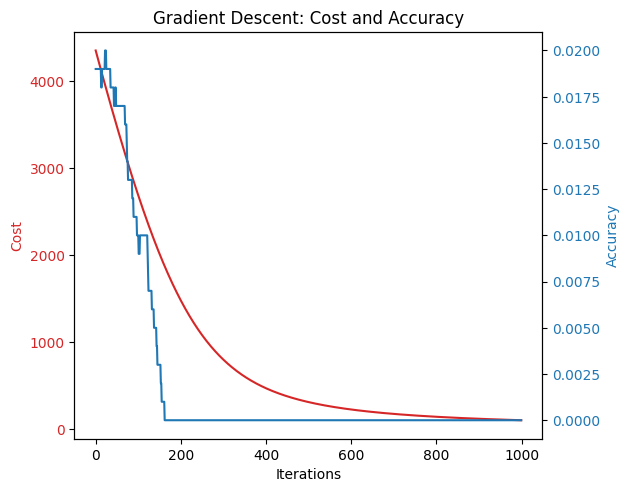

In [35]:
plot_convergence(A_cpu, H_cpu, B_cpu, M_cpu, K_cpu, update_history_GD_CPU, device='cpu')

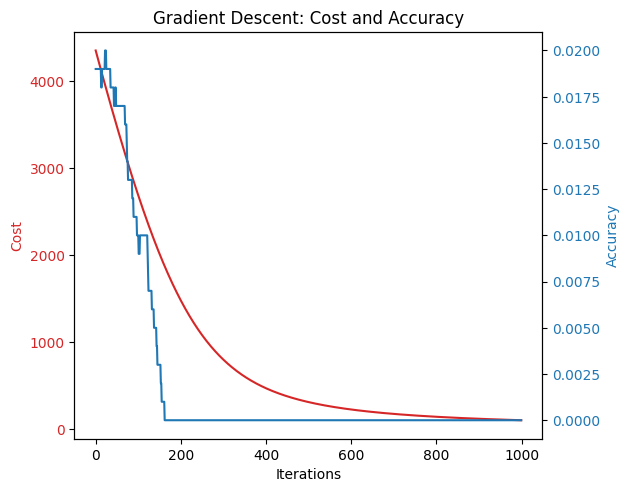

In [36]:
plot_convergence(A_gpu, H_gpu, B_gpu, M_gpu, K_gpu, update_history_GD_GPU, device='gpu')